## A quick analysis of how Philip Rivers will fit into the Colts offense

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sportsreference.nfl.teams import Teams
from sportsreference.nfl.roster import Roster, Player

from sklearn.linear_model import LinearRegression 

### Gathering Data

This analysis will investigate how Rivers' performance is related to the offensive scheme and the roster around him.

First, we will need to pull Rivers' stats throughout his career with the Chargers and some information about those team's rosters.

Next, we will take what we learn and extend it to predict how Rivers will perform with the Colts.

#### Let's use the [SportsReference API](https://github.com/roclark/sportsreference) to pull data for the Chargers for Philip's career so far and data for the Colts from last year

In [2]:
## Get Rivers' stats for all seasons
rivers = Player('RivePh00')
rivers_df = rivers.dataframe
rivers_df.drop(['2004', '2005', 'Career'], axis = 0, inplace = True)

## Pull the team rosters for the colts for 2019 and chargers from 2006-2019
for team in Teams():
    if team.abbreviation == 'CLT':
        colts_roster = team.roster

chargers_rosters = {}
SEASONS = range(2006, 2020)
for season in SEASONS:
    for team in Teams(season):
        if team.abbreviation == 'SDG':
            chargers_rosters[season] = team.roster

##### Since Rivers was in a Frank Reich offense before (2014–2015), let's see how those years compared to the rest of his career in terms of a few basic stats.

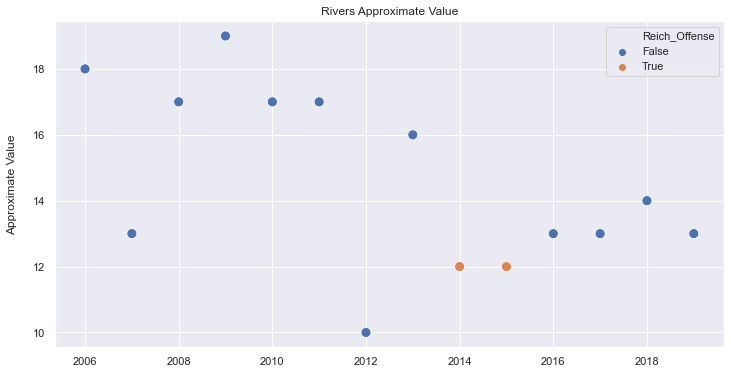

In [34]:
rivers_df['season'] = rivers_df['season'].astype(int)
rivers_df['Reich_Offense'] = rivers_df.apply(lambda x: x.season in [2014, 2015], axis = 1)

plt.figure(figsize = (12,6))
ax = sns.scatterplot(x="season", y="approximate_value", hue = 'Reich_Offense', data=rivers_df,  s= 100)
ax.set_title('Rivers Approximate Value')
ax.set(xlabel='', ylabel='Approximate Value\n')
plt.show()

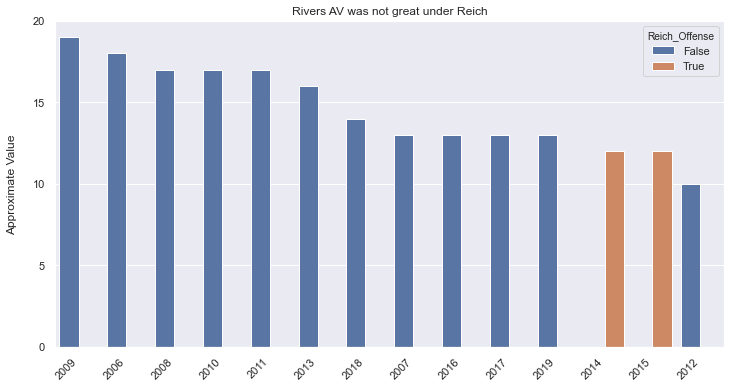

In [49]:
rivers_sorted_df = rivers_df.sort_values('approximate_value', ascending = False).reset_index(drop = True)
rivers_sorted_df['season'] = rivers_sorted_df['season'].astype(str)

plt.figure(figsize = (12,6))
ax = sns.barplot(x="season", y="approximate_value", hue = 'Reich_Offense', data=rivers_sorted_df,
                 order=rivers_sorted_df['season'])
ax.set_title('Rivers AV was not great under Reich')
ax.set(xlabel='', ylabel='Approximate Value\n')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticks((0, 5, 10, 15, 20))
plt.show()

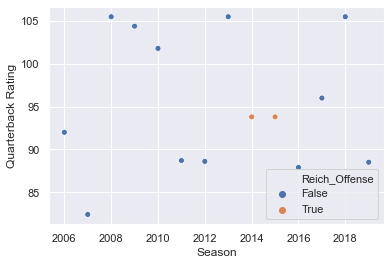

In [4]:
rivers_df['season'] = rivers_df['season'].astype(int)

ax = sns.scatterplot(x="season", y="quarterback_rating", hue = 'Reich_Offense', data=rivers_df)
ax.set(xlabel='Season', ylabel='Quarterback Rating')
plt.show()

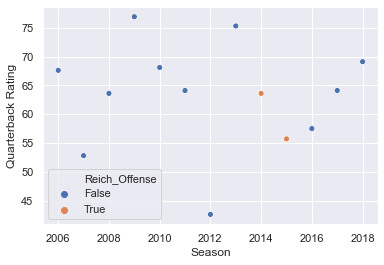

In [5]:
ax = sns.scatterplot(x="season", y="espn_qbr", hue = 'Reich_Offense', data=rivers_df)
ax.set(xlabel='Season', ylabel='Quarterback Rating')
plt.show()

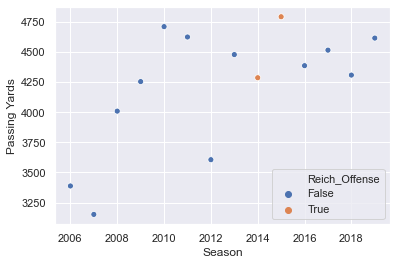

In [6]:
ax = sns.scatterplot(x="season", y="passing_yards", hue = 'Reich_Offense', data=rivers_df)
ax.set(xlabel='Season', ylabel='Passing Yards')
plt.show()

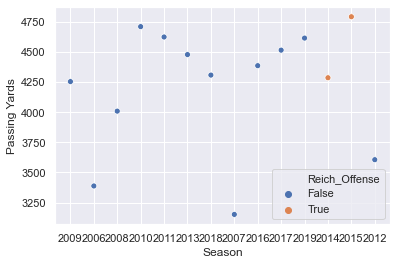

In [50]:
ax = sns.scatterplot(x="season", y="passing_yards", hue = 'Reich_Offense', data=rivers_df)
ax.set(xlabel='Season', ylabel='Passing Yards')
plt.show()

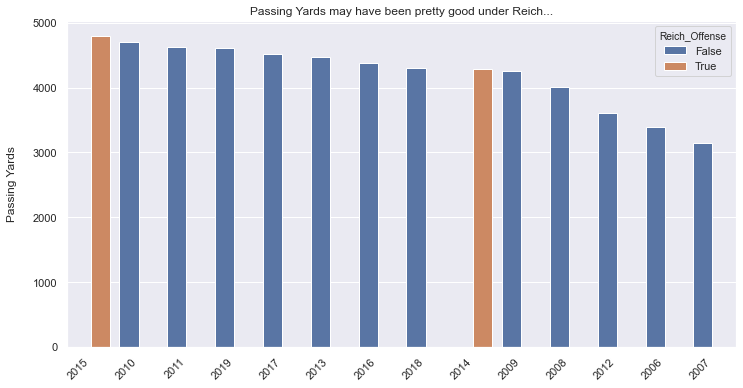

In [62]:
rivers_sorted_df = rivers_df.sort_values('passing_yards', ascending = False).reset_index(drop = True)
rivers_sorted_df['season'] = rivers_sorted_df['season'].astype(str)

plt.figure(figsize = (12,6))
ax = sns.barplot(x="season", y="passing_yards", hue = 'Reich_Offense', data=rivers_sorted_df,
                 order=rivers_sorted_df['season'])
ax.set_title('Passing Yards may have been pretty good under Reich...')
ax.set(xlabel='', ylabel='Passing Yards\n')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticks((0, 1000, 2000, 3000, 4000, 5000))
plt.show()

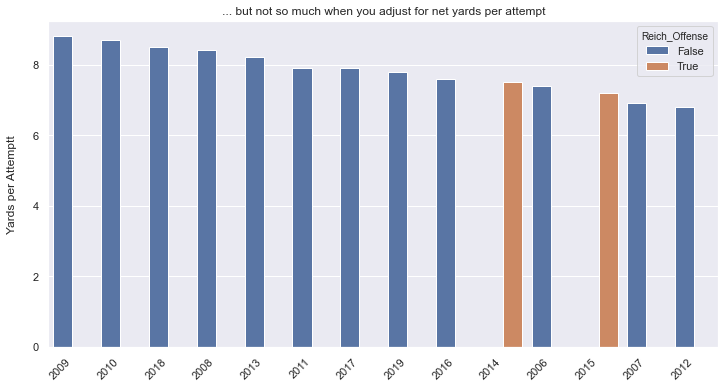

In [61]:
rivers_sorted_df = rivers_df.sort_values('passing_yards_per_attempt', ascending = False).reset_index(drop = True)
rivers_sorted_df['season'] = rivers_sorted_df['season'].astype(str)

plt.figure(figsize = (12,6))
ax = sns.barplot(x="season", y="passing_yards_per_attempt", hue = 'Reich_Offense', data=rivers_sorted_df,
                 order=rivers_sorted_df['season'])
ax.set_title('... but not so much when you adjust for net yards per attempt')
ax.set(xlabel='', ylabel='Yards per Attemptt\n')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticks((0, 2, 4, 6, 8))
plt.show()

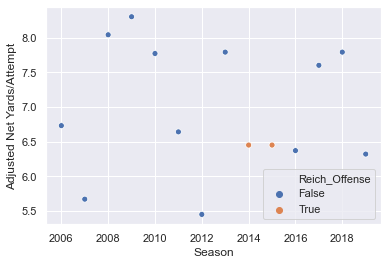

In [7]:
ax = sns.scatterplot(x="season", y="adjusted_net_yards_per_pass_attempt", hue = 'Reich_Offense', data=rivers_df)
ax.set(xlabel='Season', ylabel='Adjusted Net Yards/Attempt')
plt.show()

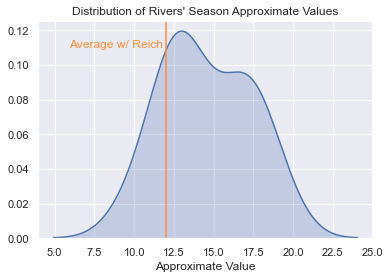

In [8]:
### Get the average Approximate Value for seasons where Reicht was OC
reich_avg = np.mean(rivers_df[rivers_df['Reich_Offense'] == True]["approximate_value"])

## Plot the distribution throughout Rivers' career and annotate the average under Frank Reich offenses
ax = sns.kdeplot(rivers_df["approximate_value"], shade = True, legend = False)
ax.set(xlabel='Approximate Value')
plt.axvline(reich_avg, 0, 1, color = '#fd8d3c')
ax.text(reich_avg-0.2, 0.11, "Average w/ Reich", horizontalalignment='right',
        size='medium', color='#fd8d3c')
ax.set_title("Distribution of Rivers' Season Approximate Values")
plt.show()

##### To quantify how correlated Rivers' performance is with the quality of the offensive line and receivers, let's first pull the stats and approximate values of those positions from each roster

In [9]:
def get_wr_oline_values(roster, season,
                        subset_positions = set(['c', 'g', 'lg', 'rg', 'og', 't',
                                                'rt', 'lt', 'ot', 'wr', 'te'])):
    """
    Helper to pull approximate values of OL and WRs for a given roster and season
    
    Returns: DataFrame
    """
    
    ## Loop through players in the roster and get values we care about
    player_names = []
    positions = []
    values = []
    rec_yds = []
    rec_tds = []
    tgts = []
    for player in roster.players:
        if player(season)._position:
            player_positions = set([pos.lower() for pos in player(season)._position
                                    if pos is not None])
            if (player_positions & subset_positions):
                player_names.append(player.name)
                positions.append((player_positions & subset_positions))
                values.append(player(season).approximate_value)
                rec_yds.append(player(season).receiving_yards)
                rec_tds.append(player(season).receiving_touchdowns)
                tgts.append(player(season).times_pass_target)
    
    ## Put it in a DF
    df = pd.DataFrame({'player_name': player_names,
                       'position': positions,
                       'approximate_value': values,
                       'rec_yds': rec_yds,
                       'rec_tds': rec_tds,
                       'targets': tgts})
    
    df['season'] = season
    
    return df

In [10]:
def summarise_stats(df,
                    o_line_positions = ['c', 'g', 'lg', 'rg', 'og',
                                        't', 'rt', 'lt', 'ot'],
                    receiver_positions = ['wr', 'te']):
    """
    Takes in result of get_wr_oline_values and summarises into variables:
        1. Max/Avg/Median O-Line Approx. values
        2. Max/Avg/Median Receiver Approx. values
        3. Max/Avg/Median Receiver yards
        4. Max/Avg/Median Receiving TDs
    
    Returns: DataFrame
    """
    
    oline_stats = (df[(((df.position != set(['wr'])) & (df.position != set(['te']))) 
                       & (~np.isnan(df['approximate_value'])))]
                   .groupby('season').agg({'approximate_value': ['max', 'mean', 'median']})
                   .rename({'approximate_value': 'oline_value'}, axis = 1)
                   .reset_index())

    receiver_stats = (df[(((df.position == set(['wr'])) | (df.position == set(['te']))) 
                       & (~np.isnan(df['approximate_value'])))]
                     .groupby('season').agg({'approximate_value': ['max', 'mean', 'median'],
                                           'rec_yds': ['max', 'mean', 'median'],
                                           'rec_tds': ['max', 'mean', 'median']})
                      .rename({'approximate_value': 'receiver_value'}, axis = 1)
                      .reset_index())
    
    stats_df = oline_stats.merge(receiver_stats)
    
    return stats_df

In [11]:
## Get the colts roster for most recent season
colts_values = get_wr_oline_values(colts_roster, '2019')

## Get it for the chargers for all relevant seasons
chargers_values = []
for season in SEASONS:
    chargers_values.append(get_wr_oline_values(chargers_rosters[season], str(season)))
chargers_values_df = pd.concat(chargers_values, sort = True)

In [12]:
colts_oline_receiver_summary = summarise_stats(colts_values)
chargers_oline_receiver_summary = summarise_stats(chargers_values_df)

In [14]:
colts_oline_receiver_summary

season oline_value              receiver_value                  rec_yds  \
                 max  mean median            max      mean median     max   
0   2019          14  9.75      9              6  2.181818      2   607.0   

                rec_tds                   
    mean median     max      mean median  
0  241.0  181.0     5.0  1.909091    2.0

#### Now we have some stats that could be predictive of Rivers' performance based on his surrounding cast.  Let's make a basic linear regression model to do the following:

    1. Understand what is most strongly correlated with a strong QB performance from Rivers
    2. Predict the approximate value for Rivers' 2020 season based on the Colts 2019 composition

In [15]:
### Merge the Rivers stats with Chargers Oline/Receiver stats in order to analyze the relationships
chargers_oline_receiver_summary['season'] = chargers_oline_receiver_summary['season'].astype(int)
rivers_regression_df = (rivers_df[['season', 'approximate_value', 'passing_yards', 'espn_qbr',
                                 'adjusted_net_yards_per_pass_attempt', 'quarterback_rating']]
                        .merge(chargers_oline_receiver_summary, on = 'season'))

C:\Users\mtdic\Anaconda3\envs\nfl\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\mtdic\Anaconda3\envs\nfl\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


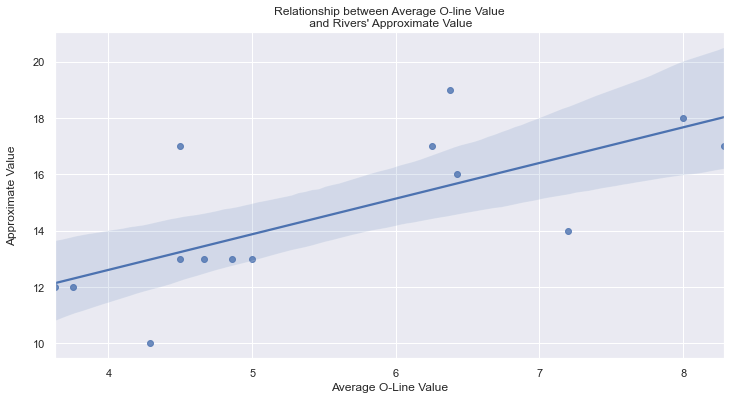

In [65]:
plt.figure(figsize = (12,6))
ax = sns.regplot(x=rivers_regression_df[('oline_value', 'mean')], 
                 y=rivers_regression_df["approximate_value"])
ax.set(xlabel='Average O-Line Value', ylabel='Approximate Value\n')
ax.set_title("Relationship between Average O-line Value\n and Rivers' Approximate Value")
plt.show()

In [69]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(rivers_regression_df[('oline_value', 'mean')],
                                                        rivers_regression_df["approximate_value"])

r_value

0.7142223679744004

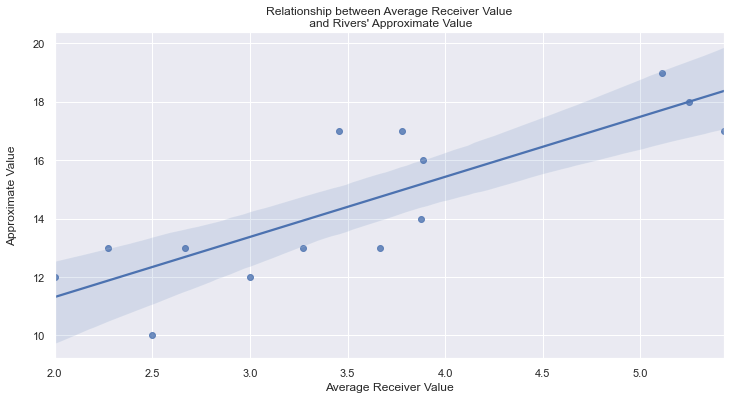

In [66]:
plt.figure(figsize = (12,6))
ax = sns.regplot(x=rivers_regression_df[('receiver_value', 'mean')], 
                 y=rivers_regression_df["approximate_value"])
ax.set(xlabel='Average Receiver Value', ylabel='Approximate Value\n')
ax.set_title("Relationship between Average Receiver Value\n and Rivers' Approximate Value")
plt.show()

In [70]:
slope, intercept, r_value, p_value, std_err = linregress(rivers_regression_df[('receiver_value', 'mean')],
                                                        rivers_regression_df["approximate_value"])

r_value

0.8279277038187849

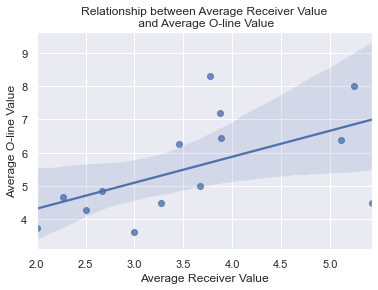

In [20]:
ax = sns.regplot(x=rivers_regression_df[('receiver_value', 'mean')], 
                 y=rivers_regression_df[('oline_value', 'mean')])
ax.set(xlabel='Average Receiver Value', ylabel='Average O-line Value')
ax.set_title("Relationship between Average Receiver Value\n and Average O-line Value")
plt.show()

In [21]:
## Get values for X and y
X = rivers_regression_df[[('oline_value', 'mean'), 
                          ('receiver_value', 'mean')]]
y = rivers_regression_df['approximate_value']

## Fit the model
reg = LinearRegression().fit(X, y)

## Print the coefficients
print(reg.coef_)

[0.6525093 1.5508733]


Receiver performance is more strongly correlated with QB performance than the O-line.  However, this does not imply ***causation***.  In football, it's hard to separate the play of the QB from the receivers and o-line since everyone is working together - their play is not independent of one another.

We also must consider the  "approximate value" features are an imperfect measure and may not tell the whole story.  But for these purposes, it's fine for an exploratory analysis.

#### Now let's see what we predict for Rivers' approximate value given the Colts O-line and receivers from 2019

In [22]:
X_pred = colts_oline_receiver_summary[[('oline_value', 'mean'),
                                       ('receiver_value', 'mean')]]

reg.predict(X_pred)

array([15.13750531])

In [73]:
X_pred = X_pred.copy()
X_pred[('oline_value', 'mean')] = X_pred[('oline_value', 'mean')]+2

reg.predict(X_pred)

array([17.74754252])

So this model predicts that Rivers would have an approximate value of about 15 with the Colts current offense.  This is about an average season for him - somewhere around 4,300 to 4,500 yards, ~30-34 TDs, and 10-12 INTs.

It's worth noting that this would be much better than the 2 seasons where Frank Reich was the OC in San Diego, where Rivers recorded an approximate value of 12 in each season.  In those seasons, the Chargers had a relatively poor offensive line, receivers, and running backs, so there is reason to be optimistic that the reunion of Reich and Rivers will be more successful this time around.